In [20]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import Flatten
import torchvision 
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
cwd = os.getcwd()
cwd

'/home/aarso2/BPI/Projeto_Semana6'

#### Criação do DataLoader de treino e validação

In [3]:
class DatasetEmotions(torch.utils.data.Dataset):
    def __init__(self,path, transforms = None):
        super().__init__()
        self.path = path
        self.images = glob.glob(os.path.join(self.path,"*_oneface/*"))
        self.labels = {"anger":0,"joy":1,"neutral":2}
        self.transforms = transforms
    def __getitem__(self,idx):
        image = cv2.imread(self.images[idx])
        if self.transforms != None: 
            image = self.transforms(image)
        return image, self.labels[self.images[idx].split("/")[-2].replace("_oneface", "")]

    def __len__(self):
        return len(self.images)

In [13]:
# Define your data folder and optional image transformations
train_path = cwd+'/BPI-MELD-main/train/train_splits_images/'
dev_path = cwd+'/BPI-MELD-main/dev/dev_splits_images/'

transforming = T.Compose([T.ToPILImage(), T.Resize((112, 112)), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Create the custom dataset and data loader
train_dataset = DatasetEmotions(train_path, transforms=transforming)
dev_dataset = DatasetEmotions(dev_path, transforms=transforming)
train_data = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_data = DataLoader(dev_dataset, batch_size=32, shuffle=True)

In [14]:
total_samples_train = len(train_data) * train_data.batch_size
total_samples_dev = len(dev_data) * dev_data.batch_size
print(f"Total de amostras no conjunto de dados de treino: {total_samples_train}")
print(f"Total de amostras no conjunto de dados de teste: {total_samples_dev}")

Total de amostras no conjunto de dados de treino: 5760
Total de amostras no conjunto de dados de teste: 672


#### Convolutional Neural Network (CNN) baseline

In [15]:
# Define the neural network model
class EmotionRecognitionNet(nn.Module):
    def __init__(self, num_classes):
        super(EmotionRecognitionNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * (112 // 8) * (112 // 8), 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
        x = self.fc_layers(x)
        return x

Final Accuracy: 35.51%


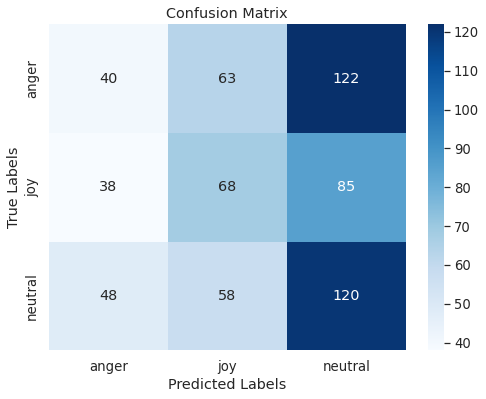

In [21]:
"""
# Number of emotion classes
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = EmotionRecognitionNet(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (assuming you have train_data DataLoader)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for batch_idx, (inputs, targets) in enumerate(train_data):
        # Move inputs and targets to the device (CPU or GPU)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print training progress
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_data)}], Loss: {loss.item():.4f}')

    # Validation
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in dev_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_predictions.extend(predicted.cpu().numpy().tolist())
            all_targets.extend(targets.cpu().numpy().tolist())

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

print('Training finished.')
"""
# Calcula a precisão final
accuracy = accuracy_score(all_targets, all_predictions)
print(f'Final Accuracy: {accuracy * 100:.2f}%')

classes = ['anger', 'joy', 'neutral']
confusion = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajusta o tamanho da fonte para tornar o gráfico mais legível
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Another CNN network

In [ ]:
class Face_Emotion_CNN(nn.Module):
  
    def __init__(self):
        super(Face_Emotion_CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.cnn1_bn = nn.BatchNorm2d(8)
        self.cnn2_bn = nn.BatchNorm2d(16)
        self.cnn3_bn = nn.BatchNorm2d(32)
        self.cnn4_bn = nn.BatchNorm2d(64)
        self.cnn5_bn = nn.BatchNorm2d(128)
        self.cnn6_bn = nn.BatchNorm2d(256)
        self.cnn7_bn = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 7)
        self.dropout = nn.Dropout(0.3)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
        x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
        x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
        x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
        x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
        x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
        x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

        x = x.view(x.size(0), -1)

        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.log_softmax(self.fc3(x))
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
face_cnn = Face_Emotion_CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs=10

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(face_cnn.parameters(), lr=1e-3)
valid_loss_min = np.Inf
train_losses, test_losses = [], []

    for e in range(epochs):
        face_cnn.train()
        running_loss = 0
        tr_accuracy = 0
        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            log_ps  = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            tr_accuracy += torch.mean(equals.type(torch.FloatTensor))
        else:
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                face_cnn.eval()
                for images, labels in dev_data:
                    images, labels = images.to(device), labels.to(device)
                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)
                    
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
            
            train_losses.append(running_loss/len(train_data))
            test_losses.append(test_loss/len(dev_data))

            print("Epoch: {}/{} ".format(e+1, epochs),
                "Training Loss: {:.3f} ".format(train_losses[-1]),
                "Training Acc: {:.3f} ".format(tr_accuracy/len(train_data)),
                "Val Loss: {:.3f} ".format(test_losses[-1]),
                "Val Acc: {:.3f}".format(accuracy/len(dev_data)))
        
plt.plot(train_losses, 'b', label='Training Loss')
plt.plot(test_losses, 'r', label='Validation Loss')
plt.show()